100%|██████████| 500/500 [01:12<00:00,  6.90it/s]


Video saved as delaunay_visualization.mp4
Base field image saved as base_field.png


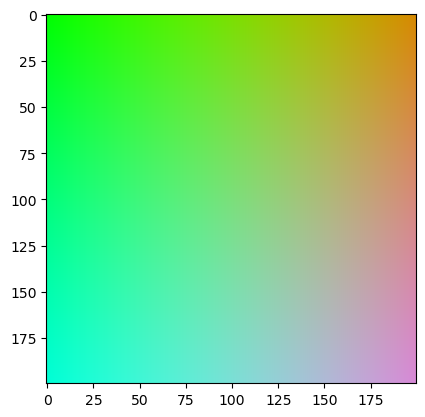

In [32]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.spatial import Delaunay
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
import mediapy

# -----------------------------
# 1. Simulation Setup Functions
# -----------------------------

def initialize_points(num_points, domain):
    """Initialize random 2D points uniformly within the domain."""
    xmin, xmax, ymin, ymax = domain
    key = jax.random.PRNGKey(0)
    points = jax.random.uniform(
        key, (num_points, 2),
        minval=jnp.array([xmin, ymin]),
        maxval=jnp.array([xmax, ymax])
    )
    return points

def initialize_velocities(num_points, velocity_scale=1.0):
    """Initialize random 2D velocities for each point."""
    key = jax.random.PRNGKey(1)
    velocities = jax.random.normal(key, (num_points, 2)) * velocity_scale
    return velocities

def update_points(points, velocities, dt):
    """Update point positions using Euler integration."""
    return points + velocities * dt

def compute_triangulation(points):
    """Compute the Delaunay triangulation for a set of points."""
    points_np = np.array(points)  # Convert to NumPy for SciPy's Delaunay
    tri = Delaunay(points_np)
    return jnp.array(tri.simplices)

def simulation_step(points, velocities, dt):
    """Perform one simulation step: update positions and compute triangulation."""
    new_points = update_points(points, velocities, dt)
    triangles = compute_triangulation(new_points)
    return new_points, triangles

# -----------------------------
# 2. Noise-Like Field and Color Query
# -----------------------------

def noise_field_extended(xy, scale=0.005):
    """
    Define a continuous field F: ℝ² → ℝ¹⁰ using sine and cosine.
    
    For colorization:
      - The first 3 coefficients are the base color (intercepts).
      - The next 6 (reshaped as (3,2)) define 3 linear functions (gradients) for RGB.
      - The 10th coefficient is extra.
    """
    x, y = xy[..., 0], xy[..., 1]
    c0 = jnp.sin(scale * x)
    c1 = jnp.cos(scale * x)
    c2 = jnp.sin(scale * y)
    c3 = jnp.cos(scale * y)
    c4 = jnp.sin(scale * (x + y))
    c5 = jnp.cos(scale * (x - y))
    c6 = jnp.sin(scale * (x - y))
    c7 = jnp.cos(scale * (x + y))
    c8 = jnp.sin(scale * (x * y))
    c9 = jnp.cos(scale * (x * y))
    return jnp.stack([c0, c1, c2, c3, c4, c5, c6, c7, c8, c9], axis=-1)

def compute_circumcenter(triangle):
    """
    Compute the circumcenter of a triangle given its 3 vertices.
    """
    a, b, c = triangle[0], triangle[1], triangle[2]
    d = 2 * (a[0]*(b[1]-c[1]) + b[0]*(c[1]-a[1]) + c[0]*(a[1]-b[1]))
    a2 = a[0]**2 + a[1]**2
    b2 = b[0]**2 + b[1]**2
    c2 = c[0]**2 + c[1]**2
    ux = (a2*(b[1]-c[1]) + b2*(c[1]-a[1]) + c2*(a[1]-b[1])) / d
    uy = (a2*(c[0]-b[0]) + b2*(a[0]-c[0]) + c2*(b[0]-a[0])) / d
    return jnp.array([ux, uy])

def query_field_at_circumcenters(triangle_verts, noise_field_fn=noise_field_extended):
    """
    For each triangle, compute its circumcenter and sample the noise field.
    """
    circumcenters = jax.vmap(compute_circumcenter)(triangle_verts)
    field_samples = jax.vmap(noise_field_fn)(circumcenters)
    return field_samples, circumcenters

def compute_vertex_colors_from_field(triangle_verts, field_samples, circumcenters):
    """
    Compute per-vertex colors for each triangle.
    
    For each vertex:
      color = base + dot(gradient, (vertex - circumcenter))
    
    - The first 3 coefficients of field_samples provide the base color.
    - The next 6 coefficients (reshaped as (3,2)) define the gradients.
    """
    base = field_samples[:, :3]  # shape (T, 3)
    gradients = field_samples[:, 3:9].reshape(-1, 3, 2)  # shape (T, 3, 2)
    offsets = triangle_verts - circumcenters[:, None, :]  # shape (T, 3, 2)
    offsets = offsets / jnp.linalg.norm(offsets, axis=-1, keepdims=True)
    grad_contrib = jnp.einsum('tcd,tvd->tvc', gradients, offsets)
    vertex_colors = base[:, None, :] + grad_contrib
    return vertex_colors

# -----------------------------
# 3. Rendering Functions (using a full static grid)
# -----------------------------

def barycentric_coords(p, a, b, c):
    """
    Compute barycentric coordinates for point(s) p with respect to triangle (a, b, c).
    
    p: shape (N,2)
    a, b, c: each shape (2,)
    Returns:
      w0, w1, w2: each shape (N,)
    """
    denom = (b[1]-c[1])*(a[0]-c[0]) + (c[0]-b[0])*(a[1]-c[1])
    w0 = ((b[1]-c[1])*(p[:, 0]-c[0]) + (c[0]-b[0])*(p[:, 1]-c[1])) / denom
    w1 = ((c[1]-a[1])*(p[:, 0]-c[0]) + (a[0]-c[0])*(p[:, 1]-c[1])) / denom
    w2 = 1.0 - w0 - w1
    return w0, w1, w2

def rasterize_triangle_update(image, verts, colors, grid_points):
    """
    Update the image with the color from a single triangle using barycentric interpolation.
    
    image: jnp.array of shape (H, W, 3)
    verts: jnp.array of shape (3, 2)
    colors: jnp.array of shape (3, 3)
    grid_points: jnp.array of shape (H, W, 2) with static coordinates.
    
    Returns:
      Updated image.
    """
    H, W, _ = grid_points.shape
    pts = grid_points.reshape(-1, 2)  # shape (H*W, 2)
    a, b, c = verts[0], verts[1], verts[2]
    w0, w1, w2 = barycentric_coords(pts, a, b, c)
    # Create a mask for points inside the triangle.
    mask = (w0 >= 0) & (w1 >= 0) & (w2 >= 0) & (w0 < 1) & (w1 < 1) & (w2 < 1) # shape (H*W,)
    # Interpolate colors for all candidate points.
    interp = w0[:, None] * colors[0] + w1[:, None] * colors[1] + w2[:, None] * colors[2]
    # Reshape to image dimensions.
    mask = mask.reshape(H, W, 1)
    interp_img = interp.reshape(H, W, 3)
    # Update the image only where mask is True.
    return image * (1 - mask) + interp_img * mask

def render_image(triangle_verts, triangle_colors, img_height, img_width):
    """
    Render the image by updating a full static grid for each triangle.
    """
    # Precompute the full static grid of pixel coordinates.
    grid_x, grid_y = jnp.meshgrid(jnp.arange(img_width), jnp.arange(img_height), indexing='xy')
    grid_points = jnp.stack([grid_x, grid_y], axis=-1)  # shape (H, W, 2)
    image = jnp.zeros((img_height, img_width, 3))
    # Loop over triangles (Python loop is acceptable for moderate counts)
    for i in range(triangle_verts.shape[0]):
        image = rasterize_triangle_update(image, triangle_verts[i], triangle_colors[i], grid_points)
    return image

# -----------------------------
# 4. Main Simulation and Video Rendering
# -----------------------------

# Simulation parameters.
num_points = 20
domain = (0.0, 200.0, 0.0, 200.0)  # (xmin, xmax, ymin, ymax)
dt = 0.1
num_frames = 500
img_height, img_width = 200, 200  # output image dimensions

# Initialize simulation.
points = initialize_points(num_points, domain)
velocities = initialize_velocities(num_points, velocity_scale=1.0)

frames = []  # To collect rendered frames.

for frame in tqdm(range(num_frames)):
    # Update simulation.
    points, simplices = simulation_step(points, velocities, dt)
    triangle_verts = points[simplices]  # shape (T, 3, 2)
    # Query field at circumcenters and compute vertex colors.
    field_samples, circumcenters = query_field_at_circumcenters(triangle_verts)
    triangle_colors = compute_vertex_colors_from_field(triangle_verts, field_samples, circumcenters)
    # Render the current frame.
    image = render_image(triangle_verts, triangle_colors, img_height, img_width)
    # image_np = np.clip((np.array(image)+100) / 500, 0.0, 1.0)
    image_np = np.clip((np.array(image)), 0.0, 1.0)
    # image_np = (image - image.min()) / (image.max() - image.min())
    frames.append((image_np * 255).astype(np.uint8))
    # print(f"Rendered frame {frame+1}/{num_frames}")

# Save frames as a video.
mediapy.show_video(frames)
# imageio.mimwrite(video_filename, frames, fps=10, quality=8)
video_filename = "delaunay_visualization.mp4"
mediapy.write_video(video_filename, frames)
print(f"Video saved as {video_filename}")

# Save a static image of the base field.
xs = jnp.linspace(domain[0], domain[1], img_width)
ys = jnp.linspace(domain[2], domain[3], img_height)
grid_x, grid_y = jnp.meshgrid(xs, ys, indexing='xy')
grid_points = jnp.stack([grid_x, grid_y], axis=-1)
field_values = noise_field_extended(grid_points)
base_color_image = np.clip(np.array(field_values[..., :3]), 0.0, 1.0)
# plt.imsave("base_field.png", base_color_image)
plt.imshow(base_color_image)

print("Base field image saved as base_field.png")